In [555]:
%config InlineBackend.figure_formats = {'png', 'retina'}
import sys
import re
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_validate, cross_val_score, GridSearchCV
from sklearn import tree
from sklearn import ensemble

plt.rcParams["figure.dpi"] = 400

In [488]:
def count_values(name):
    return name.str.count(";;") + 1


def float_to_int(float_obj):
    return float_obj.fillna(0).astype("int64")


def cv(features, outcome, use, max_depth, n_folds, n_trees):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
    if use == "ensemble":
        reg = ensemble.RandomForestRegressor(
            n_estimators=n_trees,
            min_samples_leaf=3,
            min_impurity_decrease=0.01,
            random_state=1,
        )
    else:
        reg = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=1)
    result = cross_validate(reg, features, outcome, scoring="neg_mean_squared_error")
    avg_score = np.mean(result["test_score"])
    return float(-avg_score)


def cv_mcc(features, outcome, alpha):
    cart = tree.DecisionTreeRegressor(ccp_alpha=alpha, random_state=1)
    result = cross_validate(cart, features, outcome, scoring="neg_mean_squared_error")
    avg_score = np.mean(result["test_score"])
    return float(-avg_score)

In [243]:
patents = pd.read_csv("lens-export.csv")
patents[["Inventors", "IPCR Classifications"]] = patents[
    ["Inventors", "IPCR Classifications"]
].apply(count_values)
patents[
    ["Publication Year", "Inventors", "IPCR Classifications", "Cited by Patent Count"]
] = patents[
    ["Publication Year", "Inventors", "IPCR Classifications", "Cited by Patent Count"]
].apply(
    float_to_int
)
patents.rename(
    columns={
        "Inventors": "Inventors Count",
        "IPCR Classifications": "IPCR Classifications Count",
    },
    inplace=True,
)
patents = patents[
    [
        "Publication Number",
        "Type",
        "Jurisdiction",
        "Publication Year",
        "Simple Family Size",
        "NPL Citation Count",
        "Inventors Count",
        "IPCR Classifications Count",
        "Cited by Patent Count",
    ]
]
patents["Type"] = patents["Type"].replace("unknown", np.nan)

In [244]:
print(patents.shape)

(3779, 9)


In [245]:
patents.head()

,Publication Number,Type,Jurisdiction,Publication Year,Simple Family Size,NPL Citation Count,Inventors Count,IPCR Classifications Count,Cited by Patent Count
0,US 2011/0185700 A1,Patent Application,US,2011,1,0,1,1,8
1,US 8001762 B2,Granted Patent,US,2011,4,0,2,1,2
2,US 2020/0338494 A1,Patent Application,US,2020,2,0,1,2,0
3,US 5480107 A,Granted Patent,US,1996,1,0,1,1,21
4,WO 1995/027654 A1,Patent Application,WO,1995,4,1,1,1,3


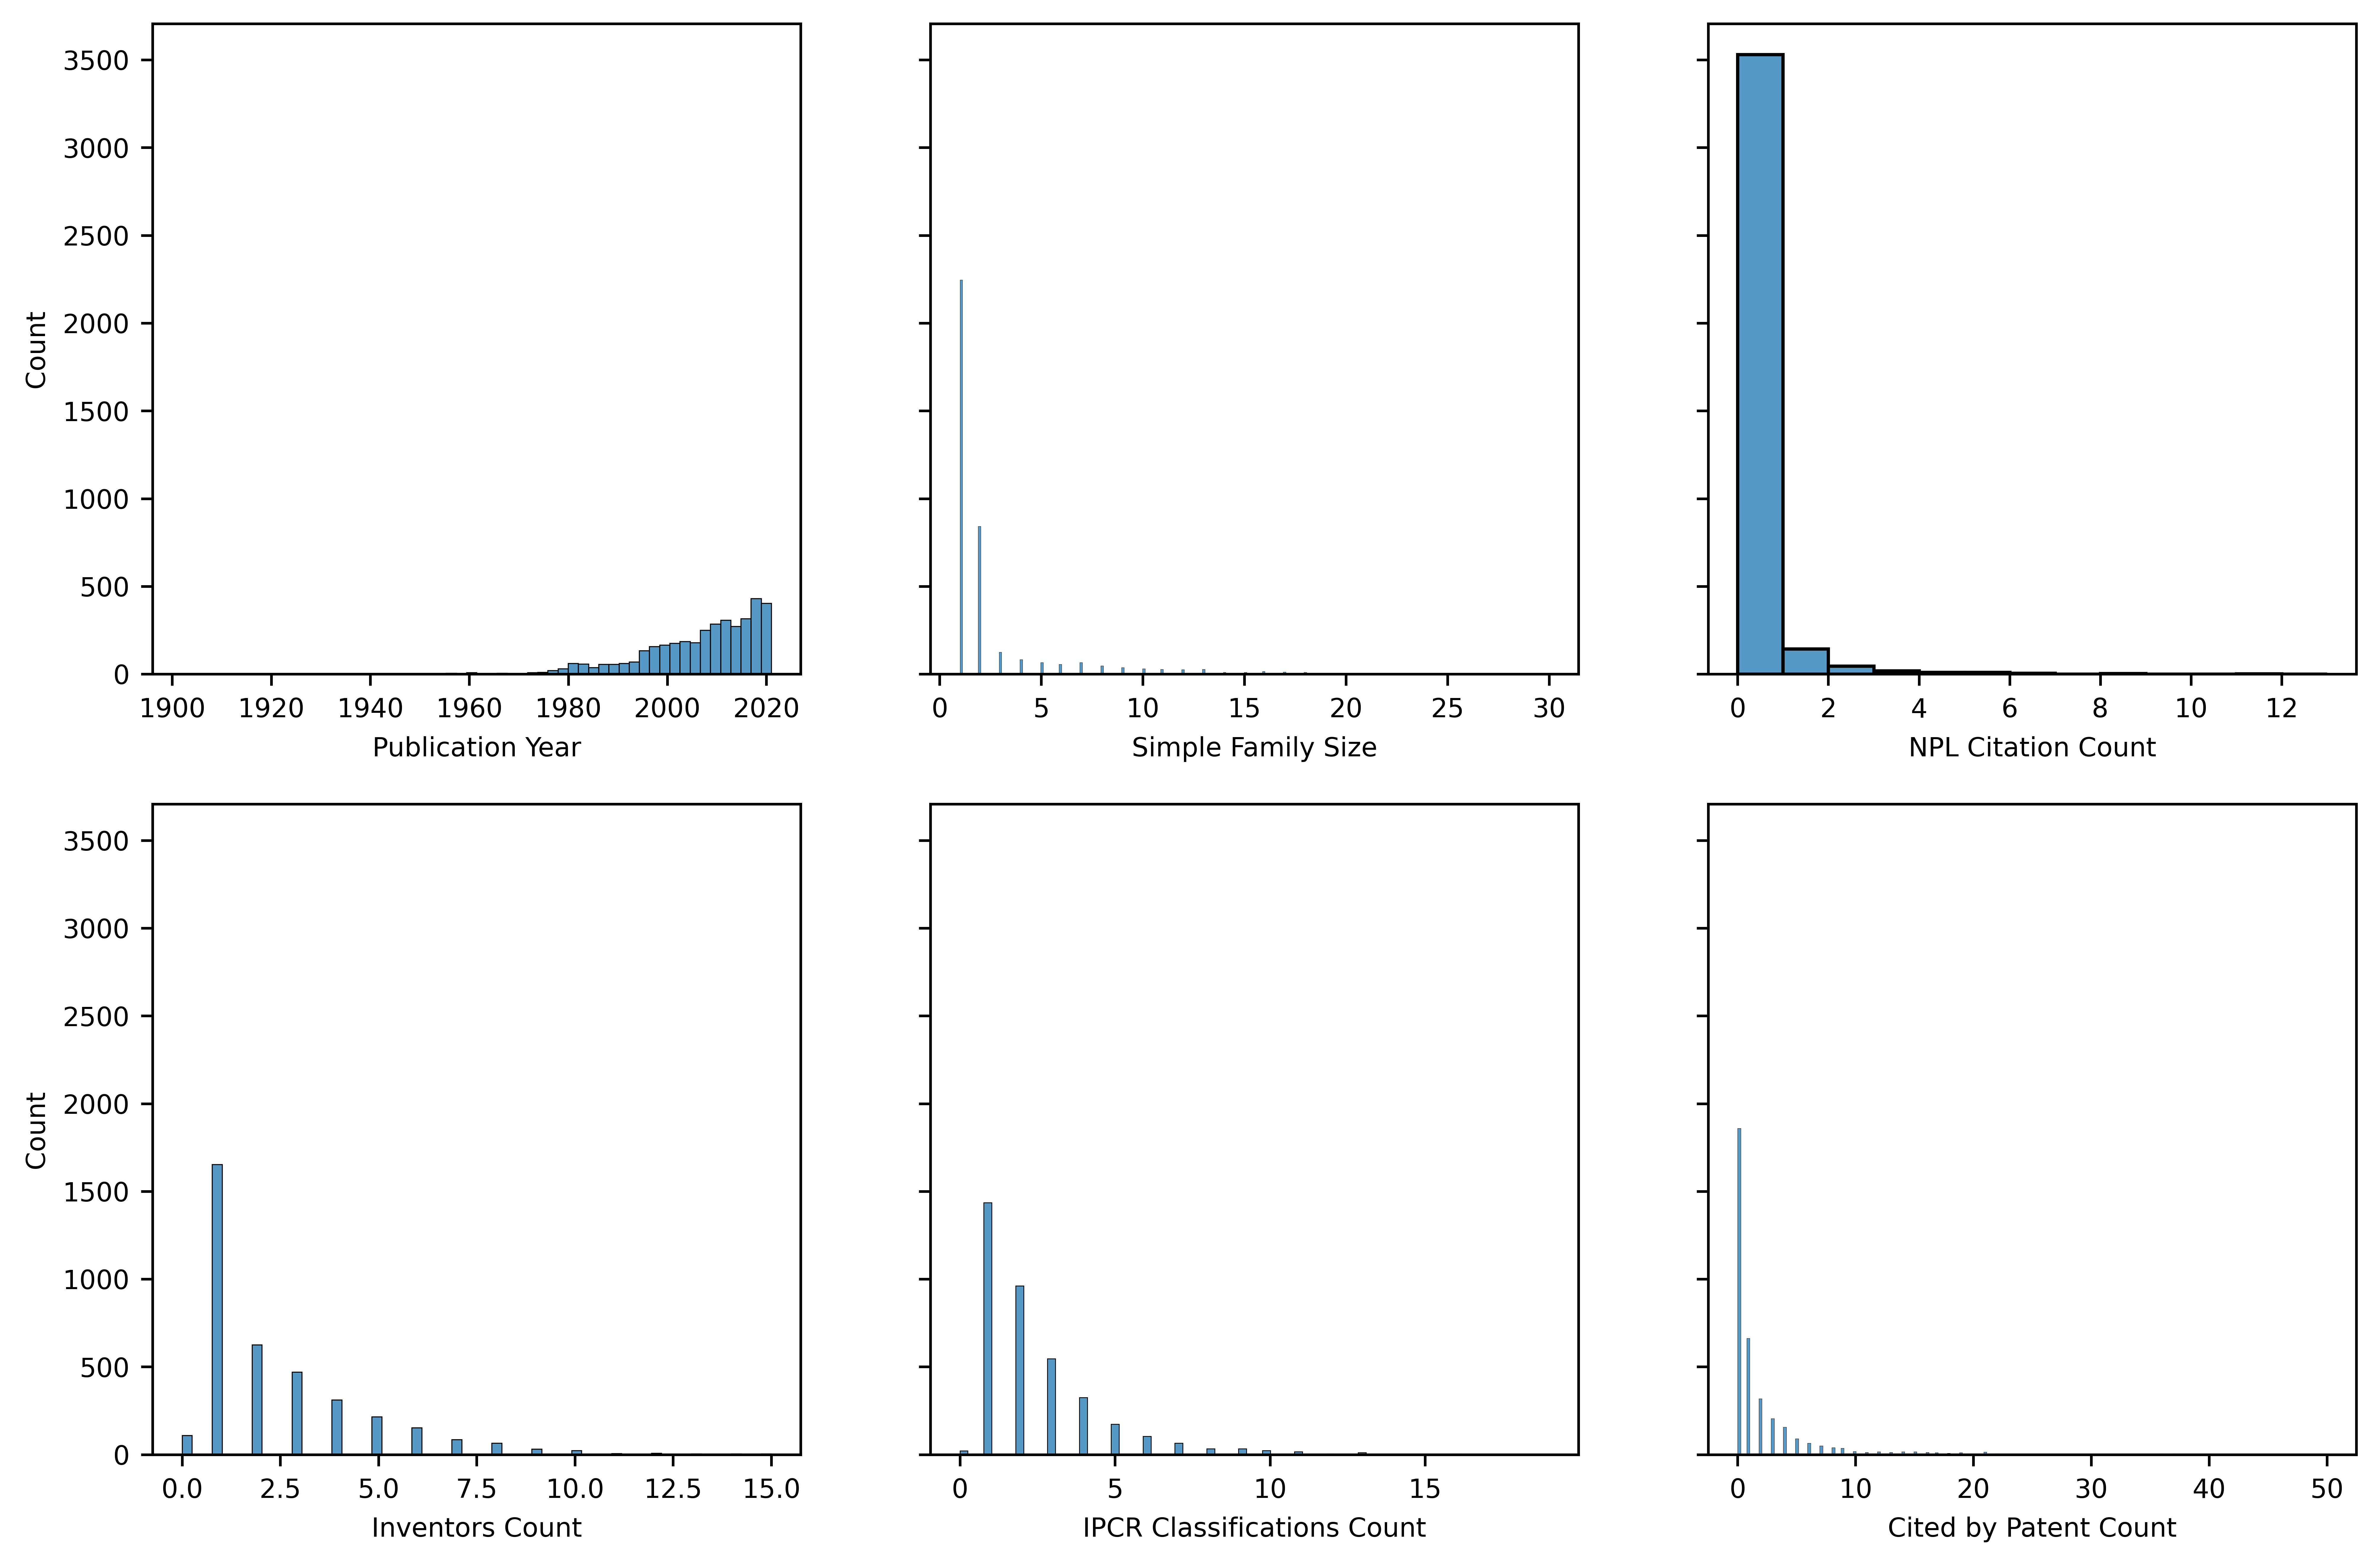

In [466]:
plt.rcParams["figure.figsize"] = [12, 8]
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharey=True)
sns.histplot(
    x="Publication Year", data=patents[patents["Publication Year"] >= 1900], ax=ax1
)
sns.histplot(
    x="Simple Family Size", data=patents[patents["Simple Family Size"] <= 30], ax=ax2
)
sns.histplot(
    x="NPL Citation Count", data=patents[patents["NPL Citation Count"] <= 15], ax=ax3
)
sns.histplot(
    x="Inventors Count", data=patents[patents["Inventors Count"] <= 15], ax=ax4
)
sns.histplot(
    x="IPCR Classifications Count",
    data=patents[patents["IPCR Classifications Count"] <= 20],
    ax=ax5,
)
sns.histplot(
    x="Cited by Patent Count",
    data=patents[patents["Cited by Patent Count"] <= 50],
    ax=ax6,
)

In [328]:
features = patents[
    patents.columns.difference(
        ["Cited by Patent Count", "Publication Number", "Publication Year"]
    )
]
features = pd.get_dummies(features, columns=["Type", "Jurisdiction"])
cited = patents["Cited by Patent Count"]
features.columns

Index(['IPCR Classifications Count', 'Inventors Count', 'NPL Citation Count',
       'Simple Family Size', 'Type_Amended Patent', 'Type_Granted Patent',
       'Type_Limited Patent', 'Type_Patent Application', 'Type_Search report',
       'Jurisdiction_AR', 'Jurisdiction_AT', 'Jurisdiction_AU',
       'Jurisdiction_BE', 'Jurisdiction_BG', 'Jurisdiction_BR',
       'Jurisdiction_CA', 'Jurisdiction_CL', 'Jurisdiction_CN',
       'Jurisdiction_CR', 'Jurisdiction_DE', 'Jurisdiction_EA',
       'Jurisdiction_EP', 'Jurisdiction_ES', 'Jurisdiction_FR',
       'Jurisdiction_GB', 'Jurisdiction_GE', 'Jurisdiction_HU',
       'Jurisdiction_IN', 'Jurisdiction_JP', 'Jurisdiction_KR',
       'Jurisdiction_LT', 'Jurisdiction_LV', 'Jurisdiction_PH',
       'Jurisdiction_PL', 'Jurisdiction_RO', 'Jurisdiction_RU',
       'Jurisdiction_SU', 'Jurisdiction_TW', 'Jurisdiction_UA',
       'Jurisdiction_US', 'Jurisdiction_WO'],
      dtype='object')

In [329]:
features_train, features_test, cited_train, cited_test = train_test_split(
    features, cited, test_size=0.2, random_state=0
)

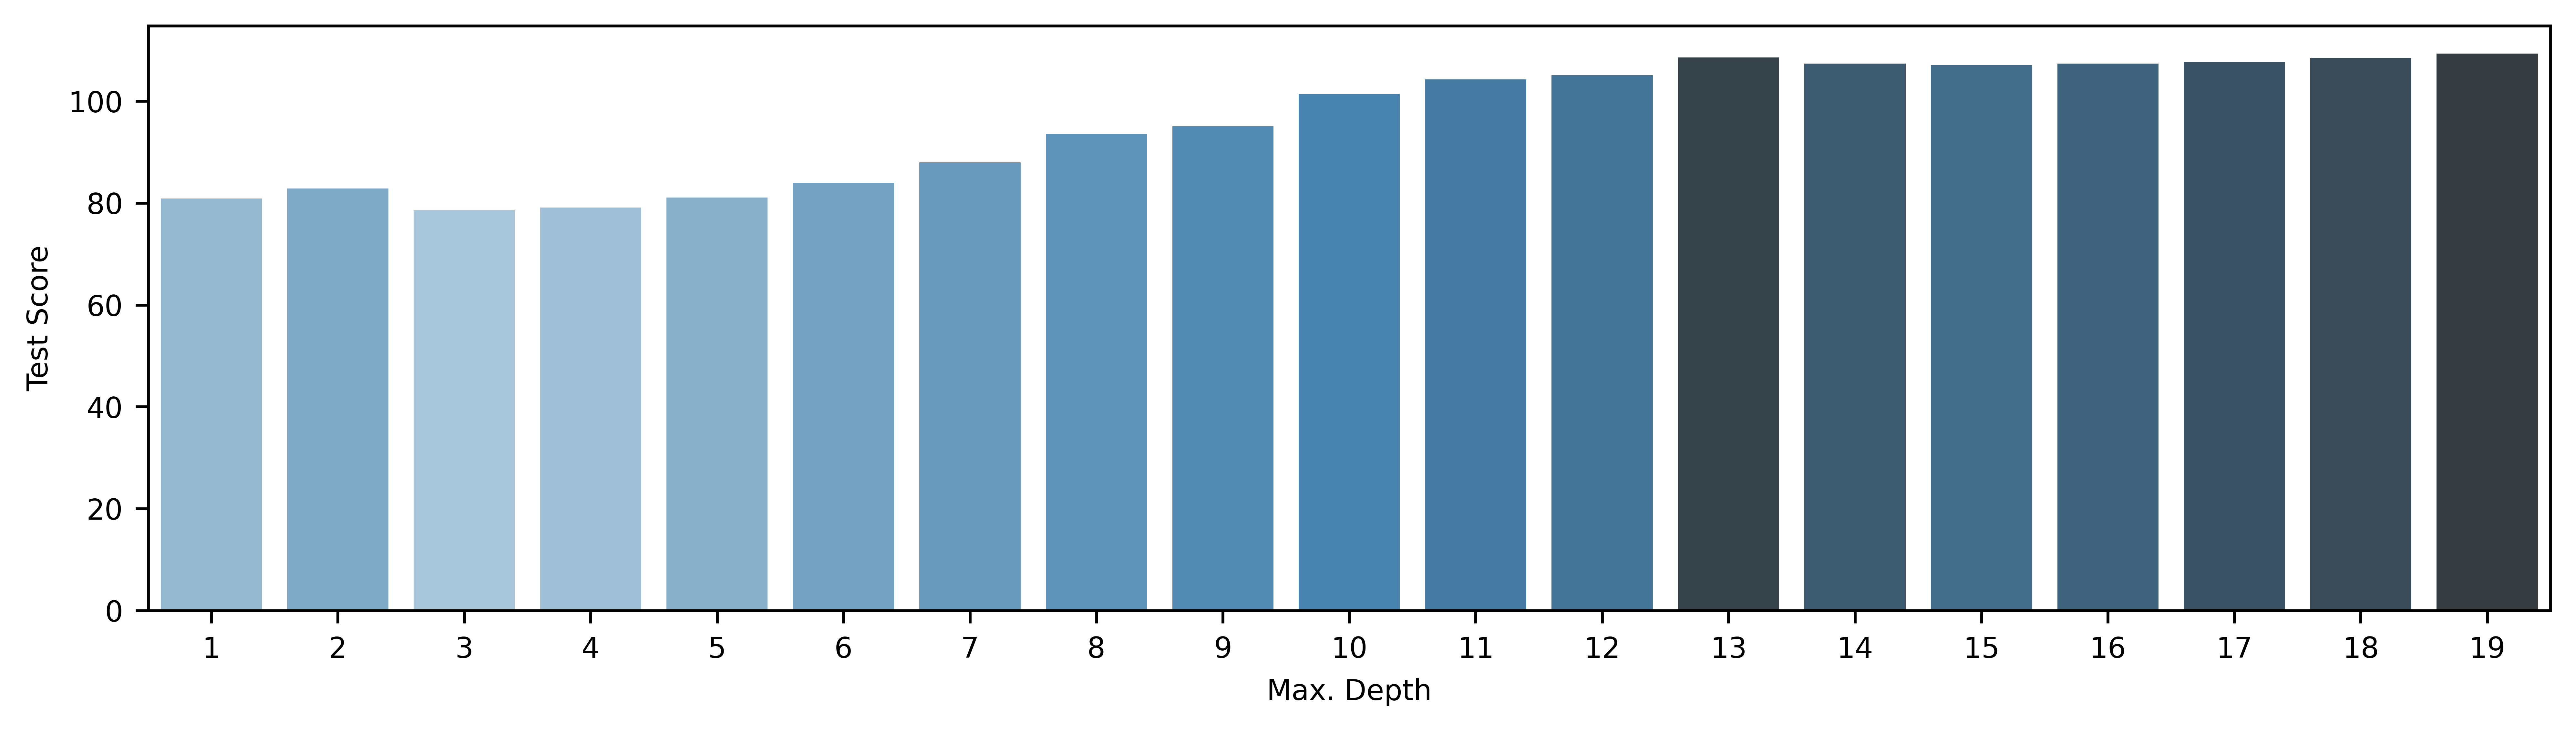

In [506]:
kfold_scores_cart = {}
for depth in range(1, 20):
    kfold_scores_cart[depth] = cv(features, cited, "tree", depth, 10, None)
plt.rcParams["figure.figsize"] = [12, 3]
kfold_scores_cart_df = pd.DataFrame.from_dict(
    kfold_scores_cart, orient="index", columns=["Test Score"]
)
cart_kfolds = sns.barplot(
    x=kfold_scores_cart_df.index,
    y=kfold_scores_cart_df["Test Score"],
    hue=kfold_scores_cart_df["Test Score"],
    dodge=False,
    palette="Blues_d",
)
cart_kfolds.set(xlabel="Max. Depth")
cart_kfolds.legend_.remove()
plt.show()

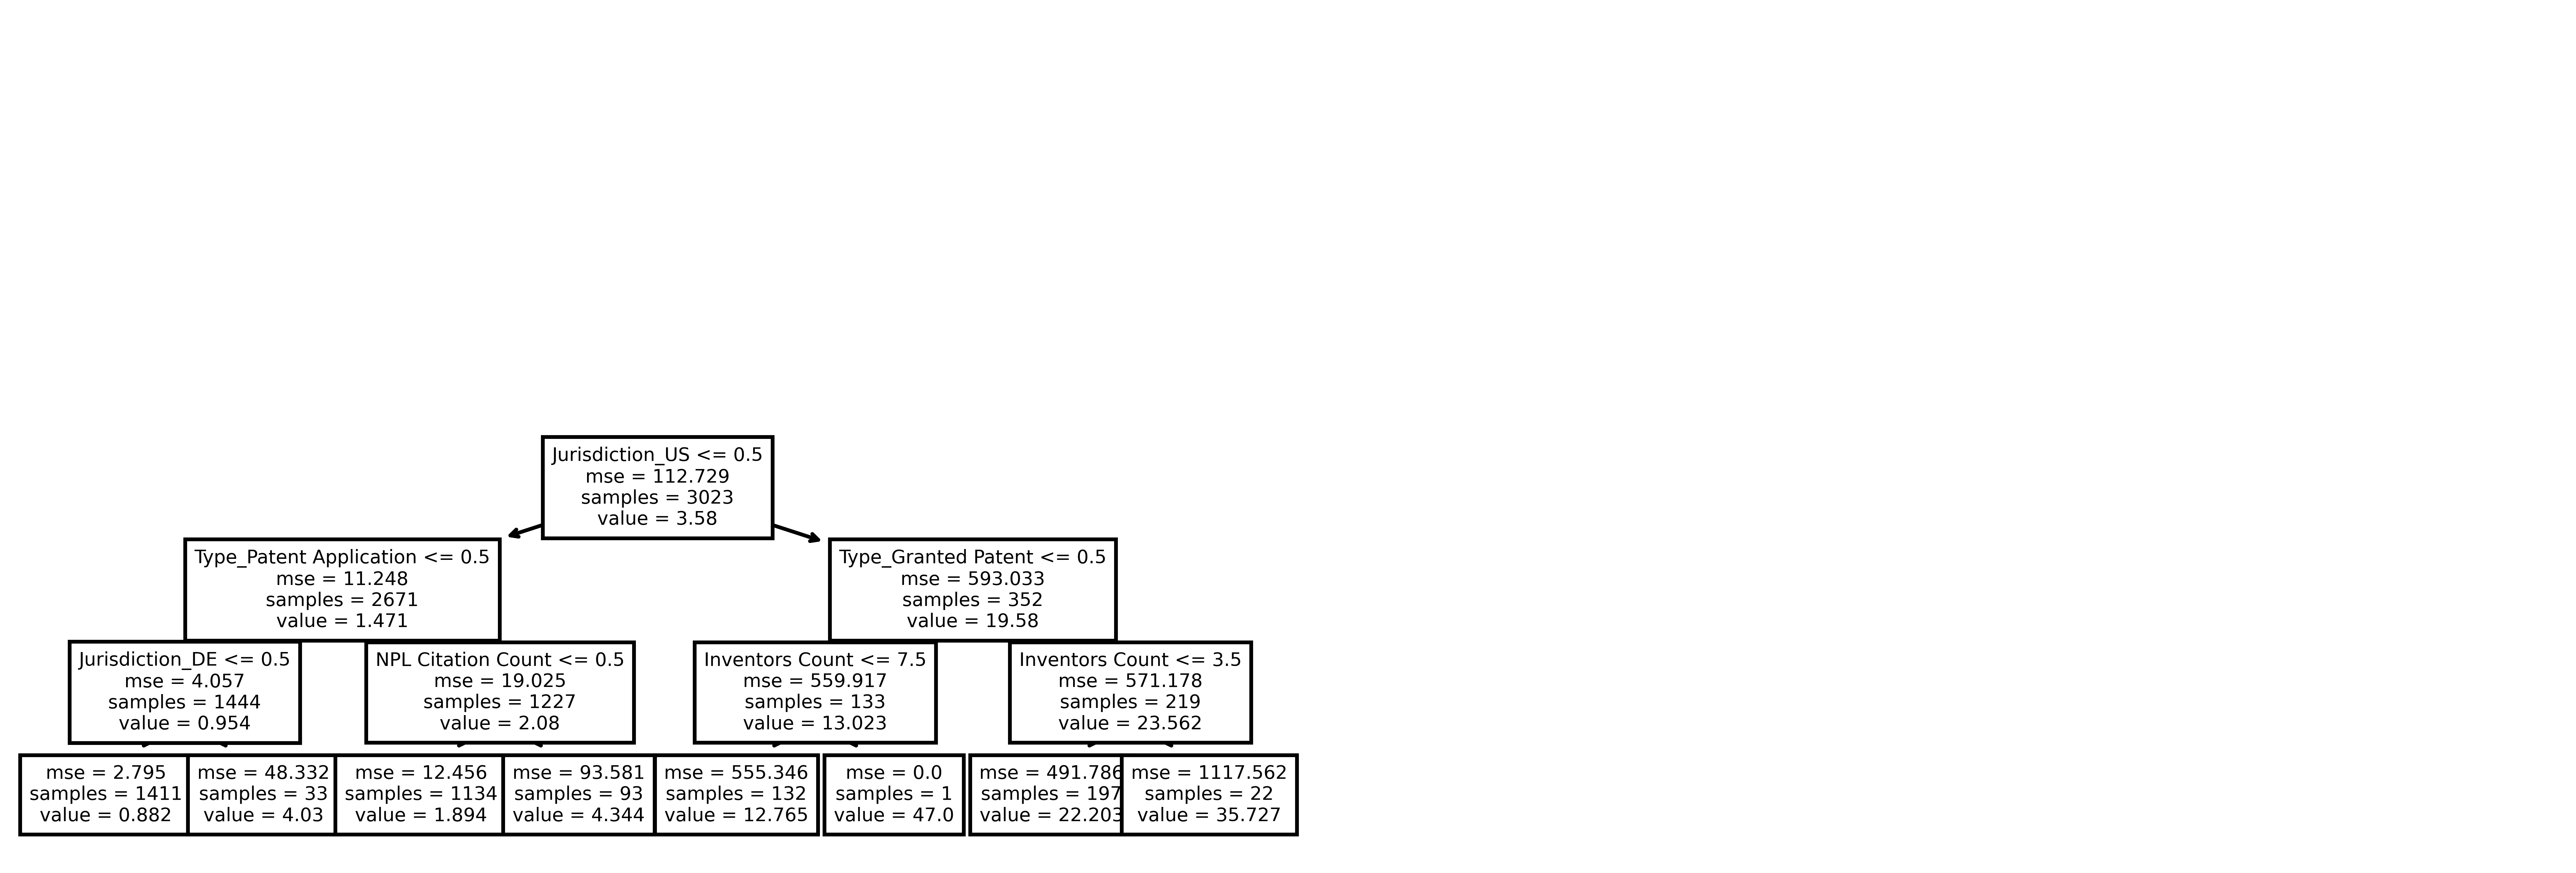

In [482]:
cart = tree.DecisionTreeRegressor(max_depth=3)
cart.fit(features_train, cited_train)
plt.rcParams["figure.figsize"] = [12, 4]
tree.plot_tree(cart, feature_names=list(features.columns))

In [331]:
cited_pred = cart.predict(features_test)
print("Tree depth: %.0f" % cart.get_depth())
print("Out-of-sample R^2, CART: %.3f" % r2_score(cited_test, cited_pred))
print("Out-of-sample MSE, CART: %.3f" % mean_squared_error(cited_test, cited_pred))

Tree depth: 3
Out-of-sample R^2, CART: 0.359
Out-of-sample MSE, CART: 76.268


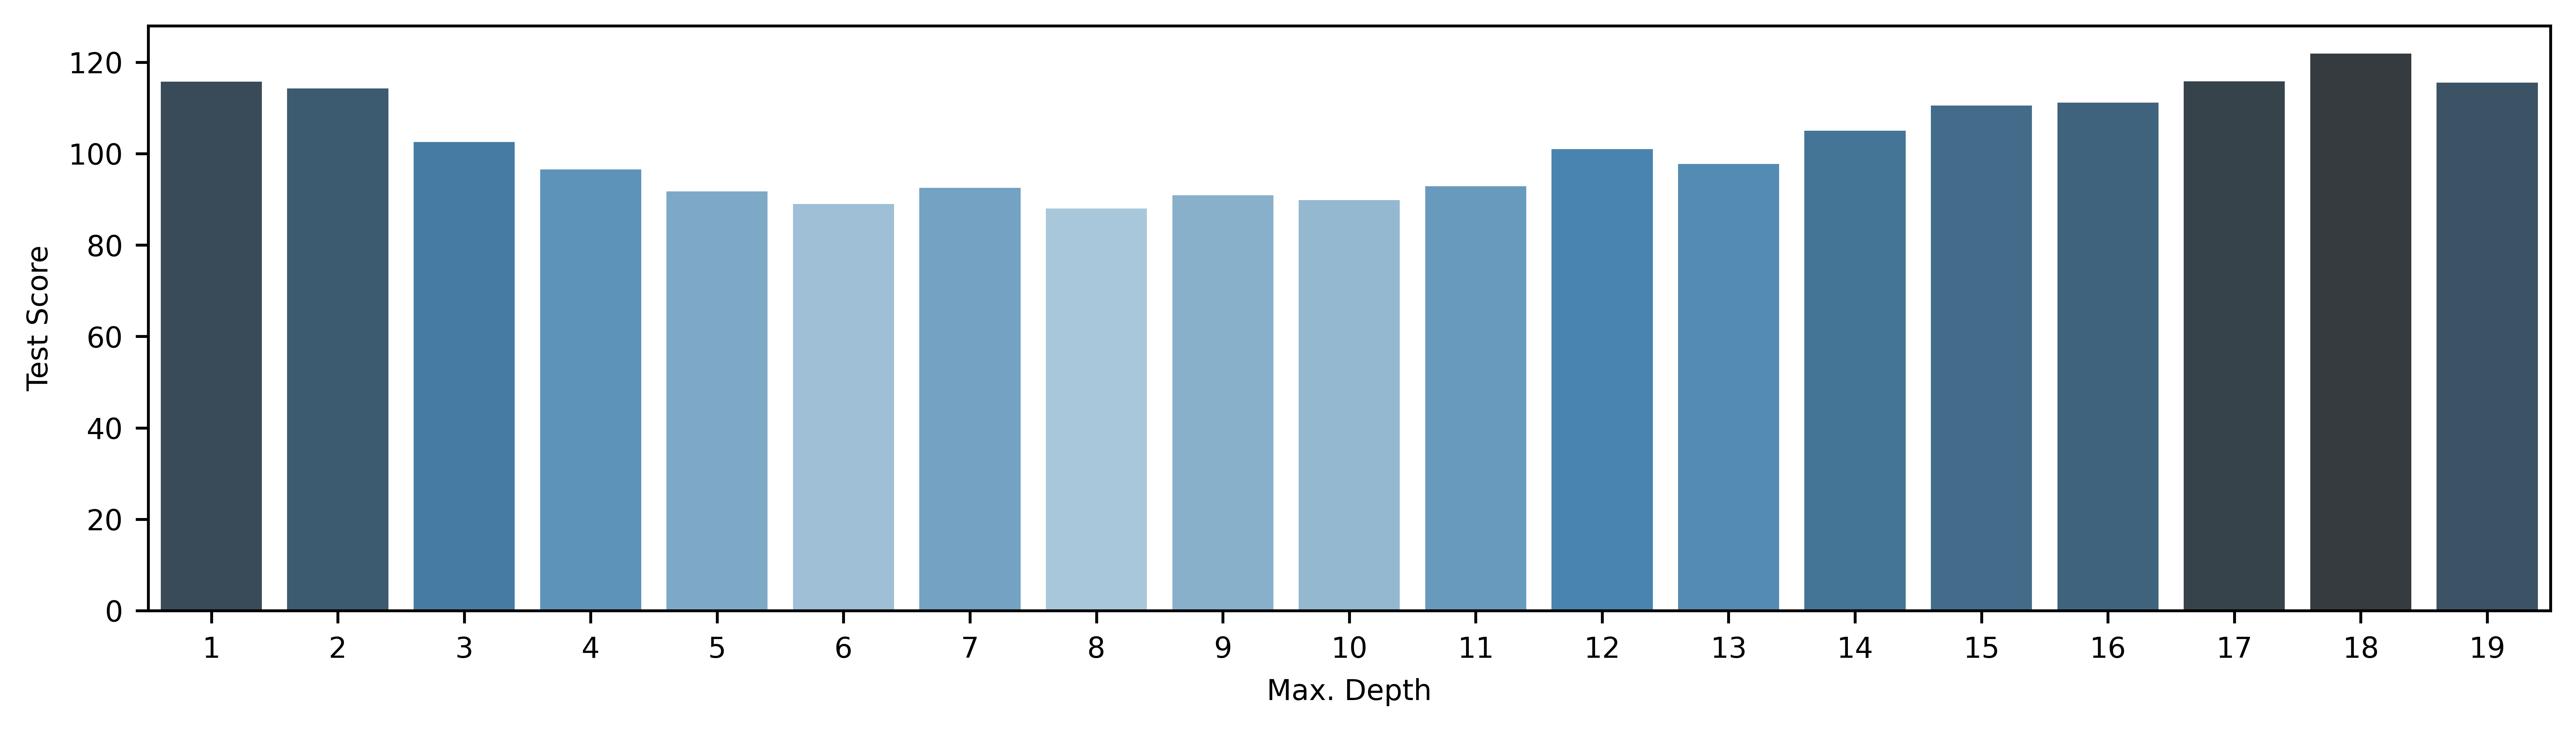

In [504]:
features_ = features[features.columns.difference(["Jurisdiction_US"])]
features__train, features__test = train_test_split(
    features_, test_size=0.2, random_state=0
)
kfold_scores_cart = {}
for depth in range(1, 20):
    kfold_scores_cart[depth] = cv(features_, cited, "tree", depth, 10, None)
plt.rcParams["figure.figsize"] = [12, 3]
kfold_scores_cart_df = pd.DataFrame.from_dict(
    kfold_scores_cart, orient="index", columns=["Test Score"]
)
cart_kfolds = sns.barplot(
    x=kfold_scores_cart_df.index,
    y=kfold_scores_cart_df["Test Score"],
    hue=kfold_scores_cart_df["Test Score"],
    dodge=False,
    palette="Blues_d",
)
cart_kfolds.set(xlabel="Max. Depth")
cart_kfolds.legend_.remove()
plt.show()

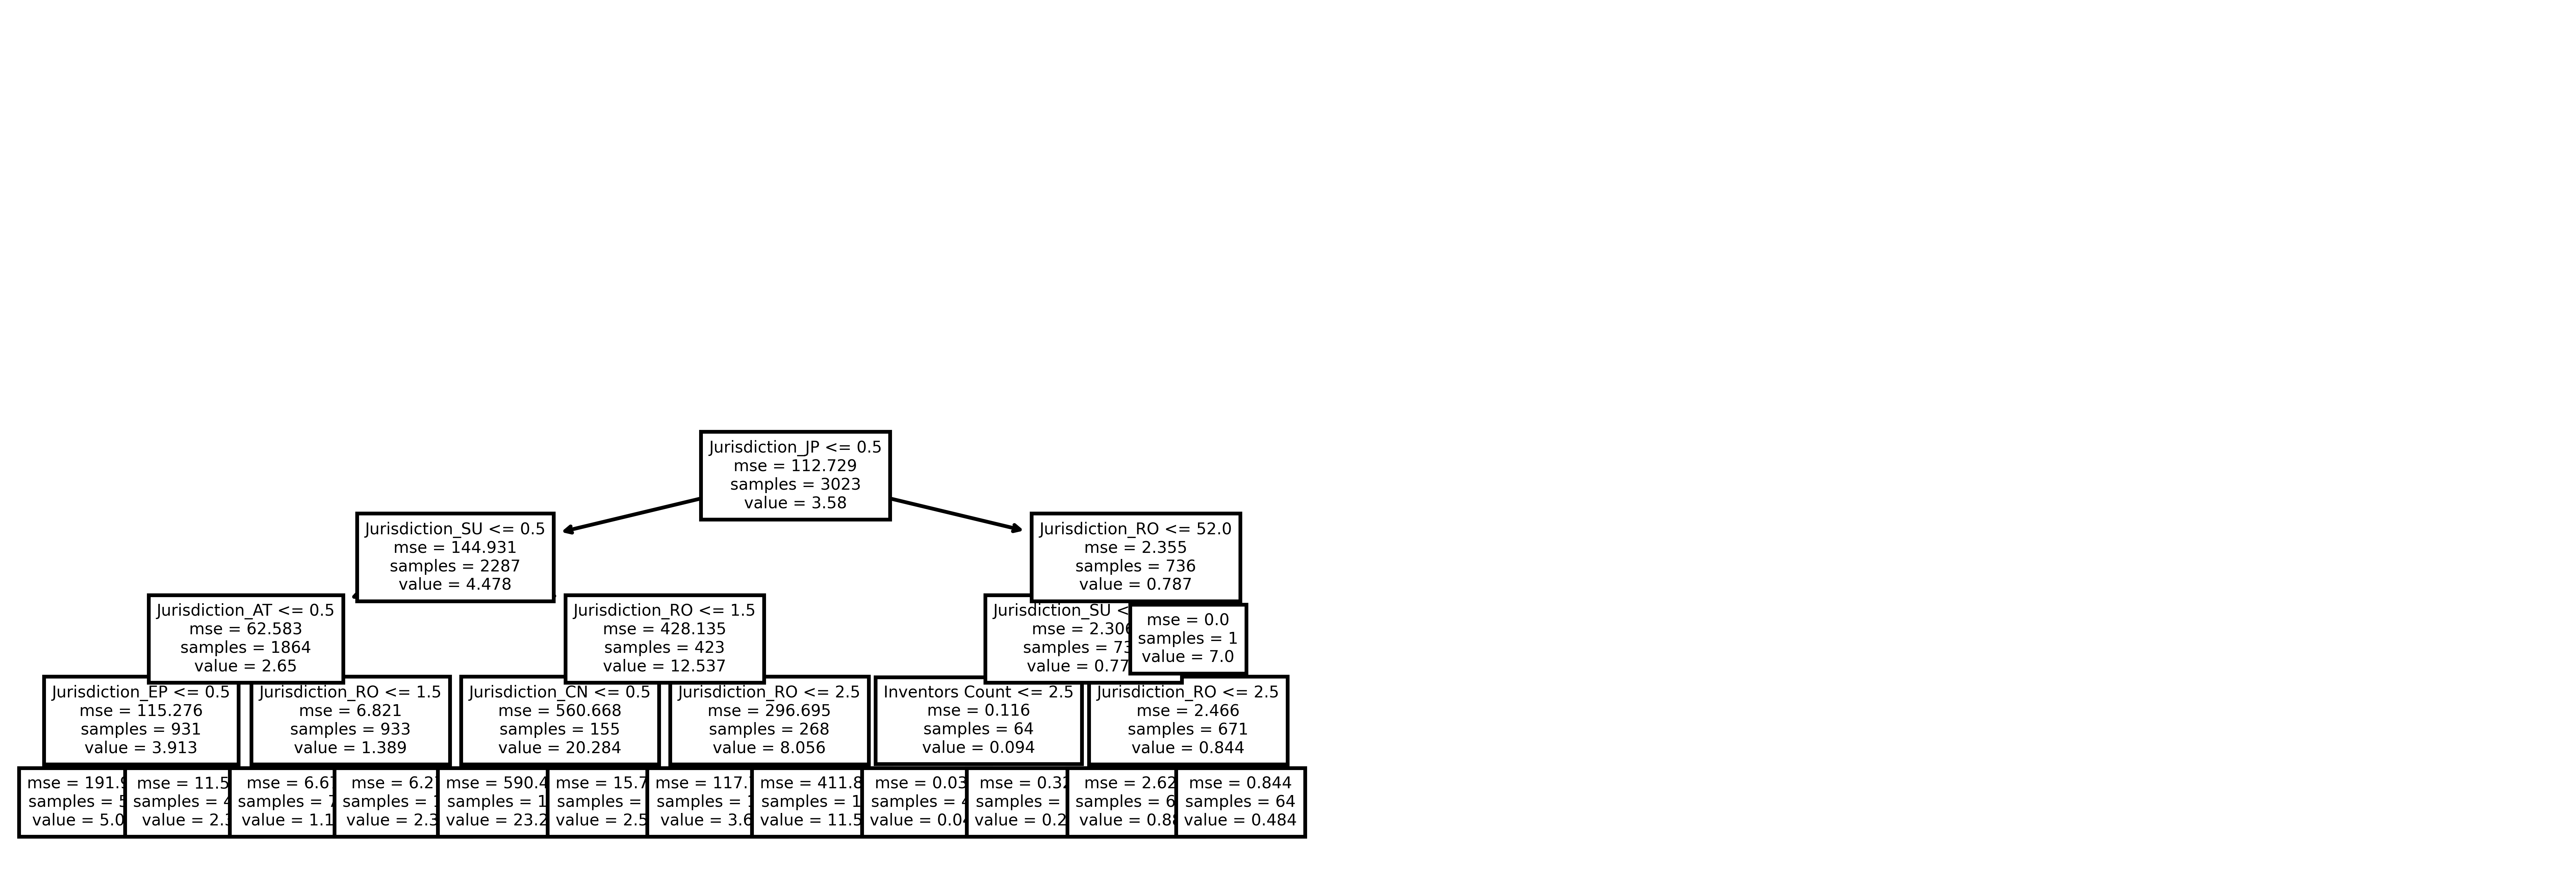

In [484]:
cart = tree.DecisionTreeRegressor(max_depth=4)
cart.fit(features__train, cited_train)
plt.rcParams["figure.figsize"] = [12, 4]
tree.plot_tree(cart, feature_names=list(features.columns))

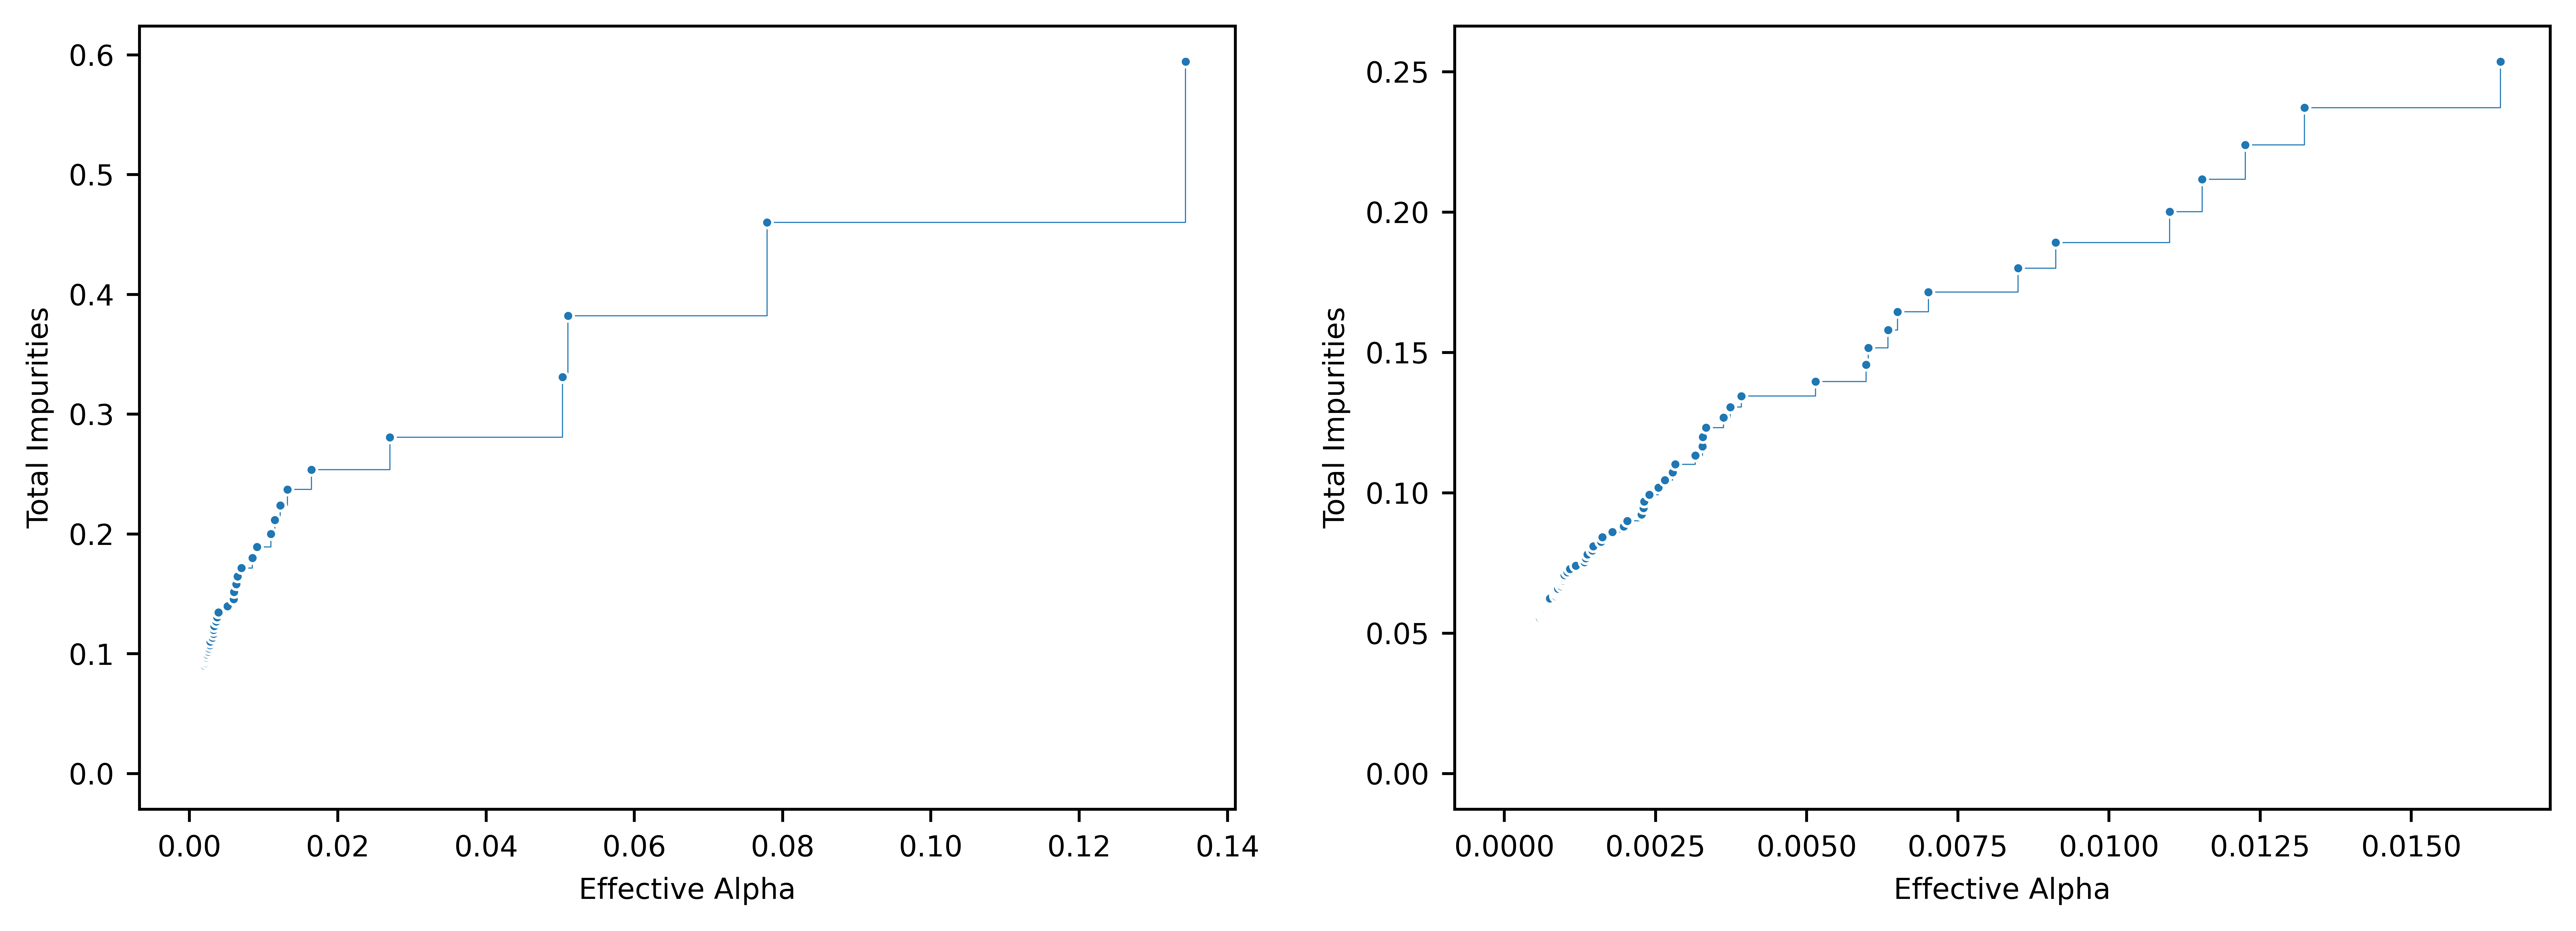

In [487]:
cart = tree.DecisionTreeRegressor(random_state=1)
path = cart.cost_complexity_pruning_path(features_train, features_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
alphas_impurities = pd.DataFrame(
    {"Effective Alpha": ccp_alphas[:-1], "Total Impurities": impurities[:-1]}
)
plt.rcParams["figure.figsize"] = [12, 4]
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.lineplot(
    x="Effective Alpha",
    y="Total Impurities",
    data=alphas_impurities,
    marker="o",
    drawstyle="steps-post",
    linewidth=0.3,
    markersize=3,
    ax=ax1,
)
sns.lineplot(
    x="Effective Alpha",
    y="Total Impurities",
    data=alphas_impurities[alphas_impurities["Effective Alpha"] <= 0.02],
    marker="o",
    drawstyle="steps-post",
    linewidth=0.3,
    markersize=3,
    ax=ax2,
)

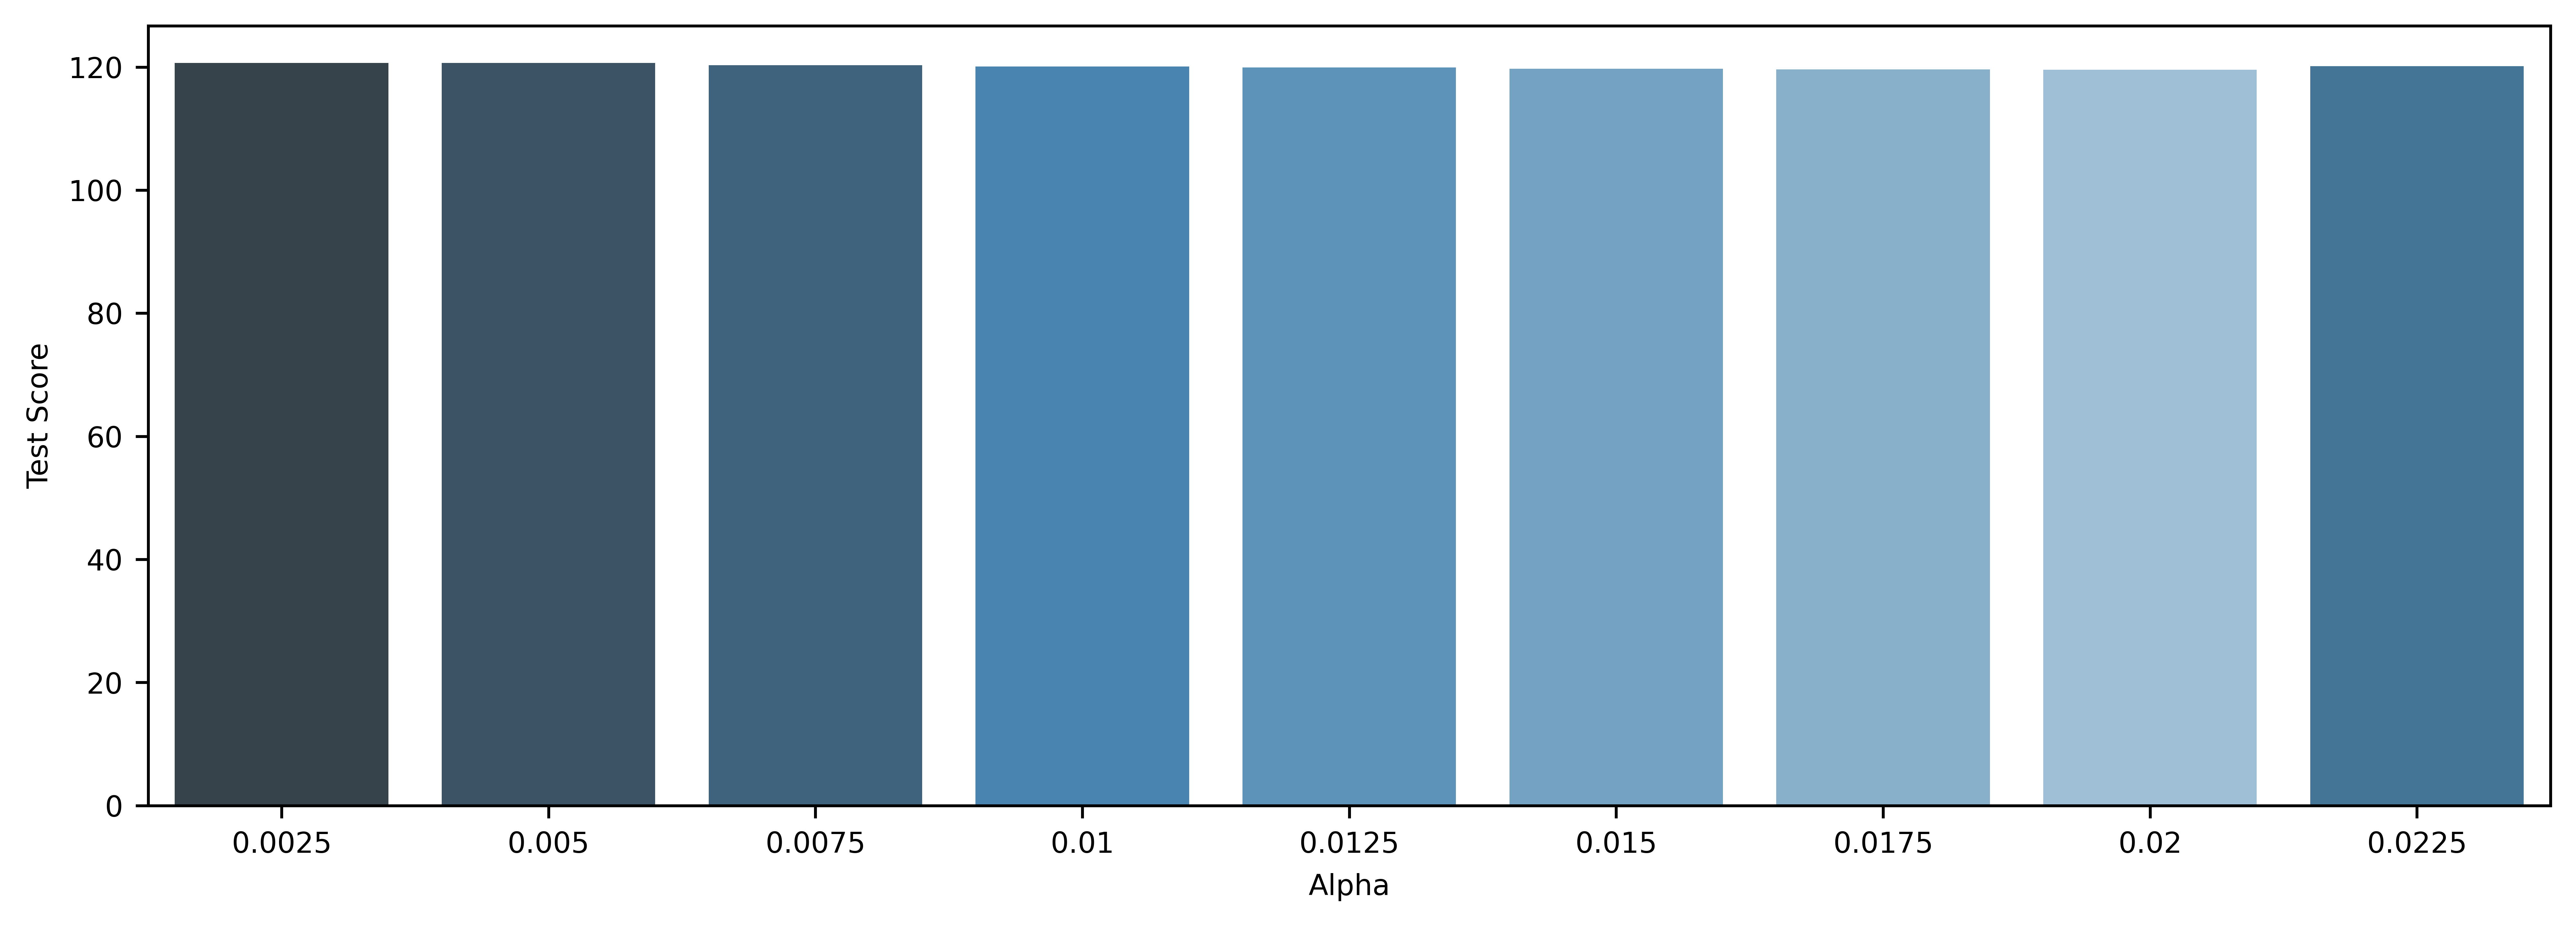

In [515]:
alpha_trials = {}
for alpha in [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225]:
    alpha_trials[alpha] = cv_mcc(features_train, cited_train, alpha)
plt.rcParams["figure.figsize"] = [12, 4]
alpha_trials_df = pd.DataFrame.from_dict(
    alpha_trials, orient="index", columns=["Test Score"]
)
cart_alphas = sns.barplot(
    x=alpha_trials_df.index,
    y=alpha_trials_df["Test Score"],
    hue=alpha_trials_df["Test Score"],
    dodge=False,
    palette="Blues_d",
)
cart_alphas.set(xlabel="Alpha")
cart_alphas.legend_.remove()
plt.show()

In [516]:
cart = tree.DecisionTreeRegressor(ccp_alpha=0.02, random_state=1)
cart = cart.fit(features_train, cited_train)
cited_pred = cart.predict(features_test)
print("Tree Depth: %.0f" % cart.get_depth())
print("Out-of-sample R^2: %.3f" % r2_score(cited_test, cited_pred))
print("Out-of-sample MSE: %.3f" % mean_squared_error(cited_test, cited_pred))

Tree Depth: 15
Out-of-sample R^2: -0.094
Out-of-sample MSE: 130.045


In [421]:
kfold_scores_rf = {}
for n_trees in range(1, 200, 10):
    kfold_scores_rf[n_trees] = cv(
        features_train, cited_train, "ensemble", None, 3, n_trees
    )

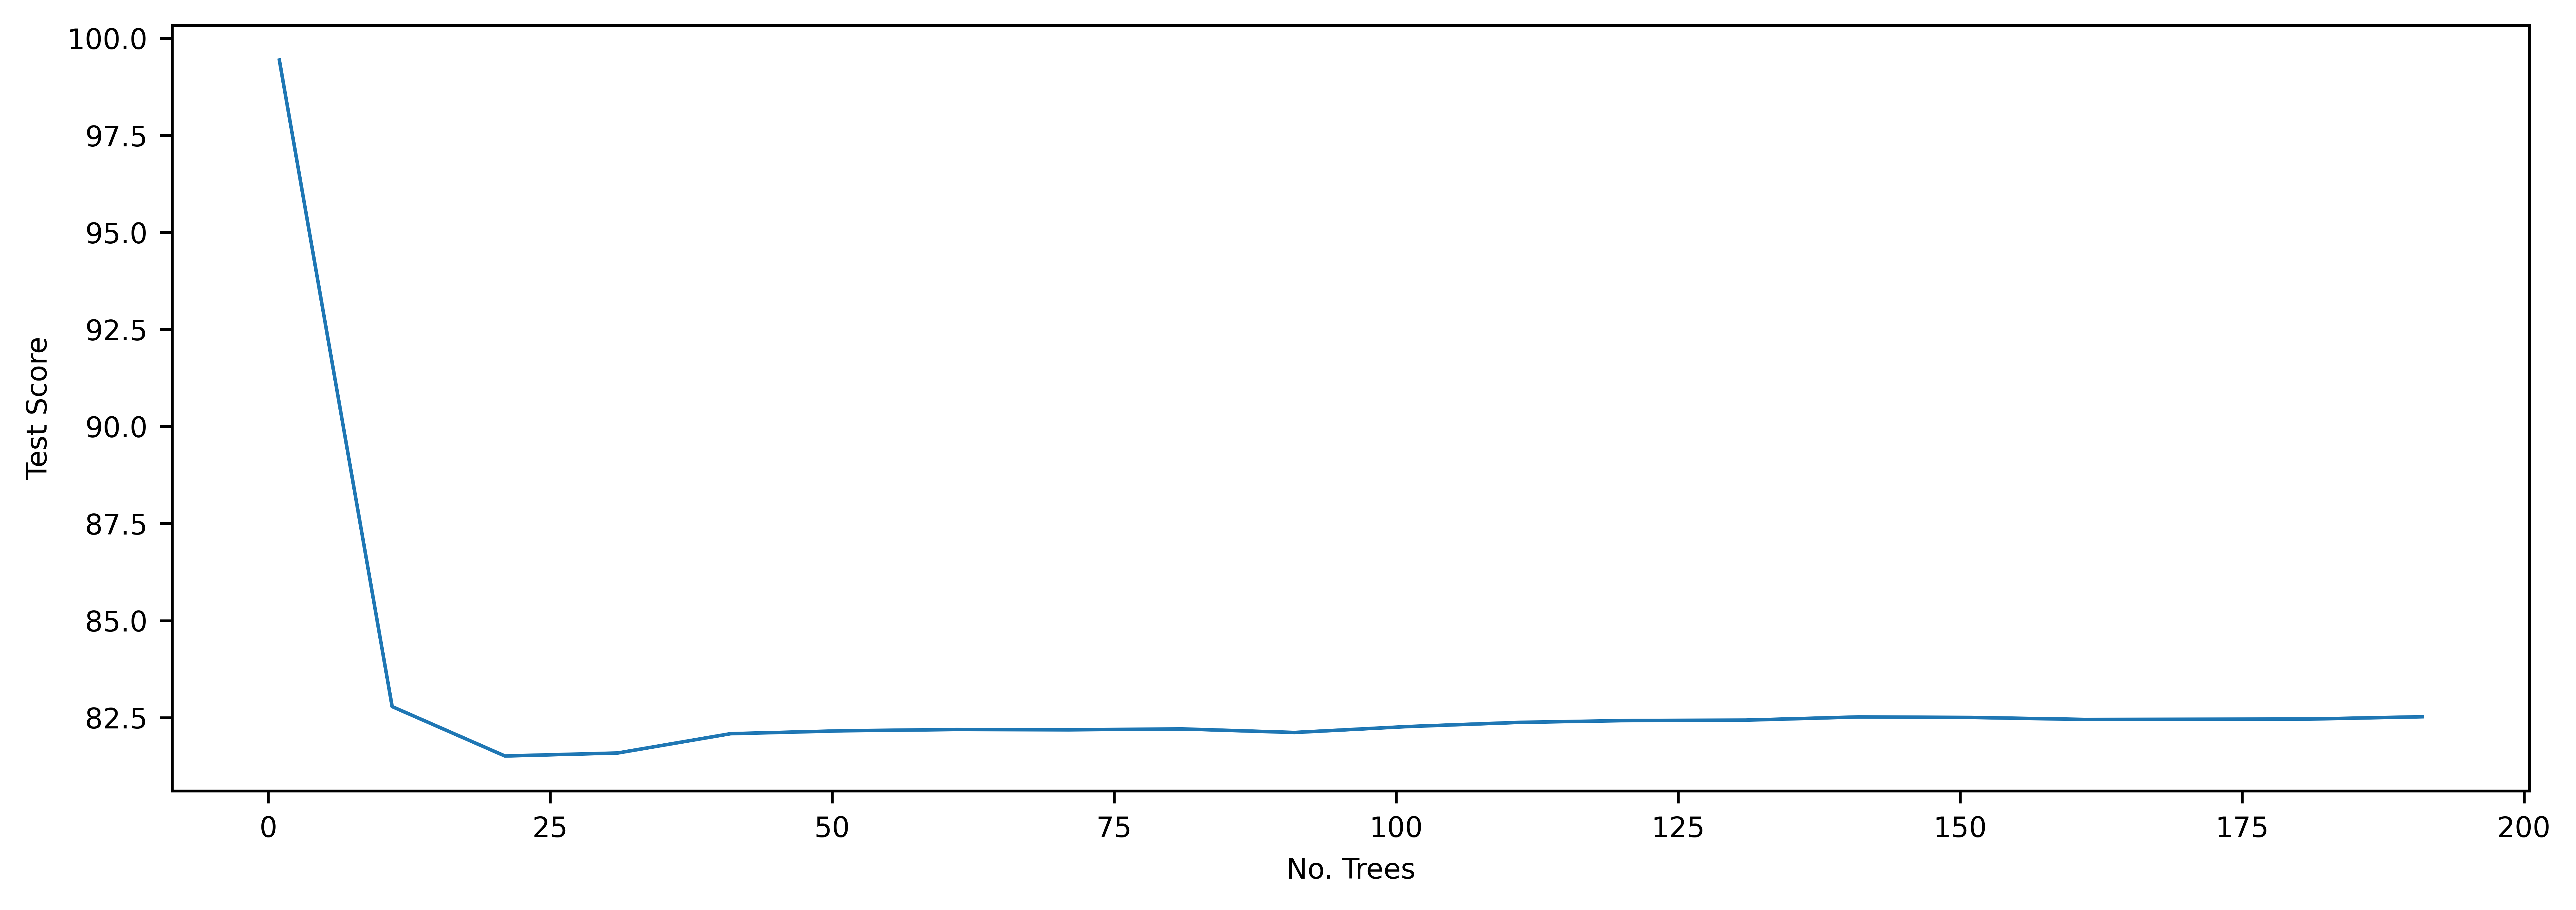

In [518]:
plt.rcParams["figure.figsize"] = [12, 4]
pd.DataFrame(kfold_scores_rf.items(), columns=["No. Trees", "Test Score"])
kfold_scores_rf_df = pd.DataFrame(
    kfold_scores_rf.items(), columns=["No. Trees", "Test Score"]
)
sns.lineplot(x="No. Trees", y="Test Score", data=kfold_scores_rf_df, linewidth=1)

In [557]:
params = {
    "n_estimators": np.arange(20, 30),
    "max_features": ["auto", "sqrt"],
    "max_depth": np.arange(1, 13),
    "min_samples_split": [5, 10],
}
rf_tuned = GridSearchCV(
    estimator=ensemble.RandomForestRegressor(), param_grid=params, cv=10, verbose=0
)
rf_tuned.fit(features_train, cited_train)
cited_pred = rf_tuned.predict(features_test)
rf_tuned.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 28}

In [558]:
print("Out-of-sample R^2: %.3f" % r2_score(cited_test, cited_pred))
print("Out-of-sample MSE: %.3f" % mean_squared_error(cited_test, cited_pred))

Out-of-sample R^2: 0.360
Out-of-sample MSE: 76.114


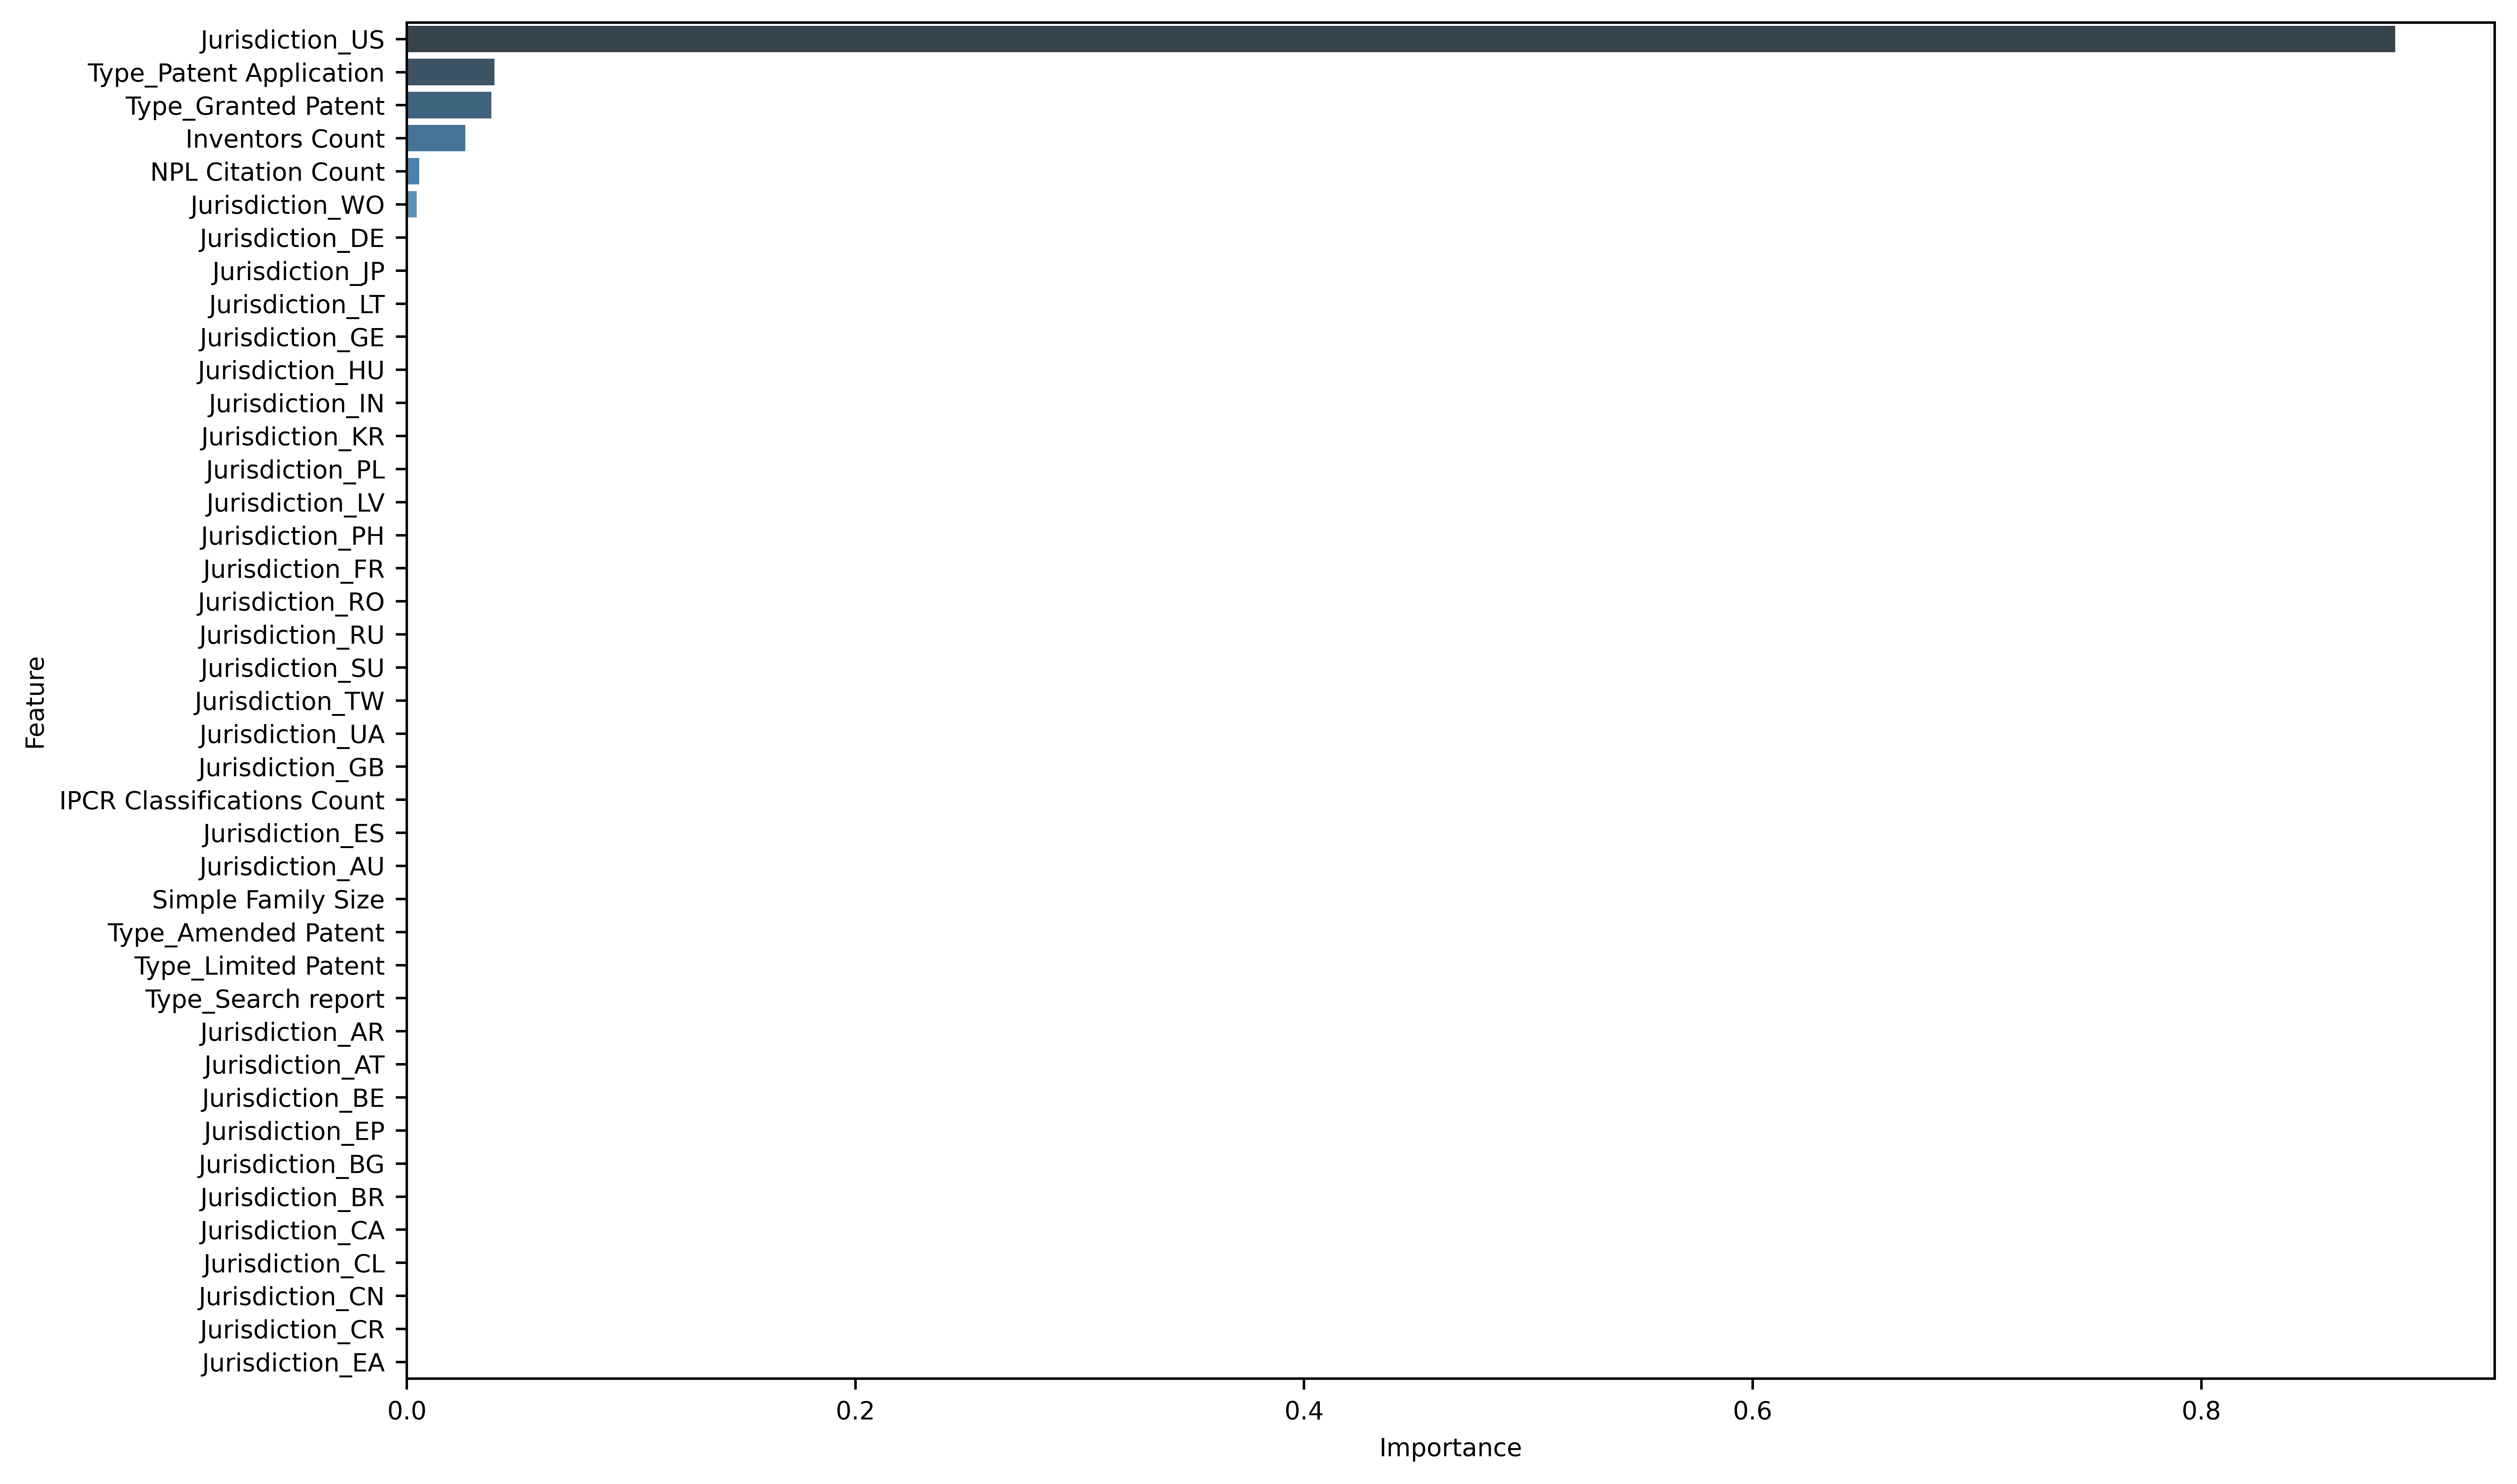

In [553]:
feature_names = list(features.columns.values)
ordered_features_df = pd.DataFrame(
    {
        "Feature": list(features.columns.values),
        "Importance": rf_tuned.best_estimator_.feature_importances_,
    }
).sort_values(by=["Importance"], ascending=False)
plt.rcParams["figure.figsize"] = [12, 8]
ordered_features = sns.barplot(
    x="Importance",
    y="Feature",
    data=ordered_features_df,
    hue=ordered_features_df["Importance"],
    dodge=False,
    palette="Blues_d",
)
ordered_features.legend_.remove()
plt.show()